<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MGE-Pvalb"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/MGE-Pvalb/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


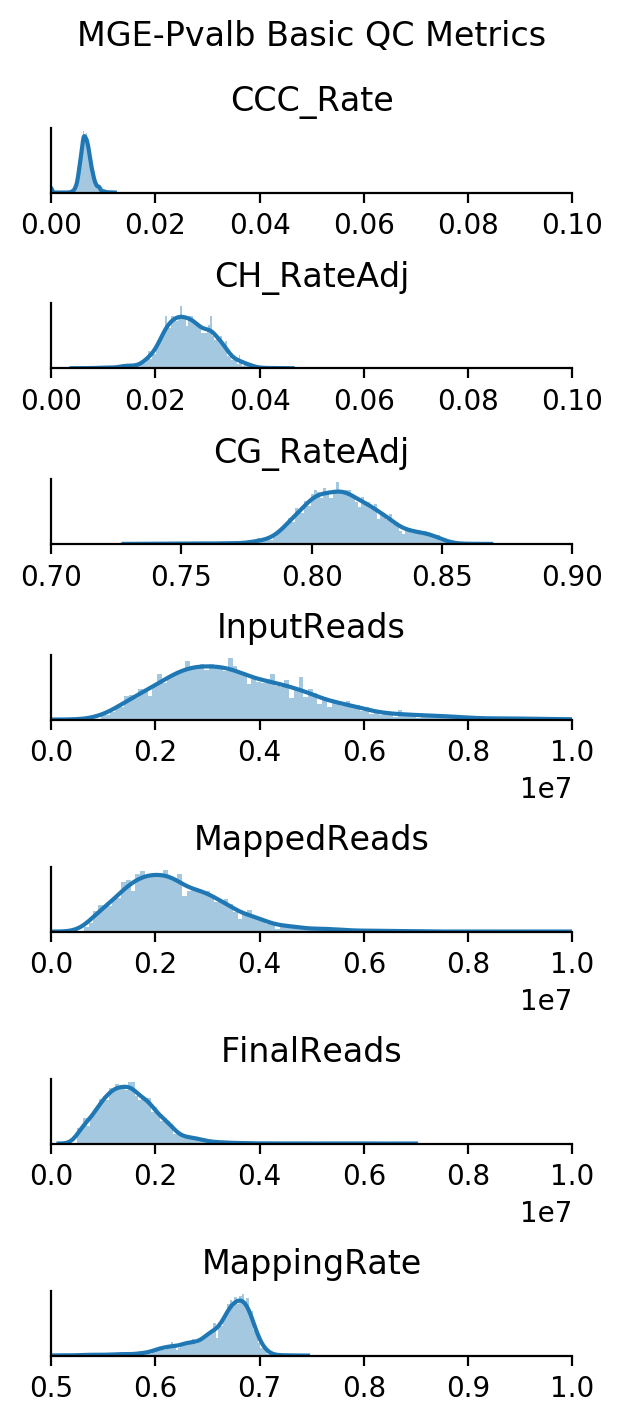

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

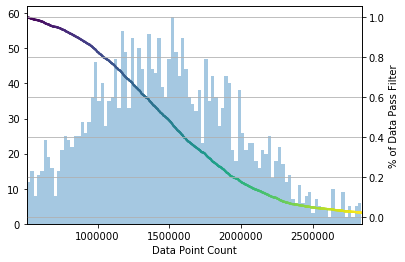

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2636/2636 (100.0%)
CG_RateAdj passed 2636/2636 (100.0%)
CH_RateAdj passed 2636/2636 (100.0%)
FinalReads passed 2636/2636 (100.0%)
MappingRate passed 2636/2636 (100.0%)
Overall passed 2636/2636 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 43
171207 68
171212 10
171213 75
171214 1
171219 1
180104 58
180109 8
180119 68
180122 41
180123 36
180129 40
180130 53
180205 35
180206 25
180208 9
180212 11
180213 42
180220 47
180222 35
180226 49
180227 28
180305 44
180306 81
180312 61
180313 13
180319 5
180320 40
180326 27
180329 26
180402 25
180403 33
180405 14
180409 44
180410 64
180412 41
180416 46
180417 32
180419 48
180423 60
180424 36
180426 78
180430 73
180501 60
180514 43
180529 63
180605 33
180612 52
180917 1
181002 66
181008 21
181009 28
181022 38
181023 45
181204 8
181210 70
181218 2
181220 14
190108 26
190117 26
190122 73
190124 87
190131 25
190205 69
190212 3
190214 24
190219 3
190305 29
190307 44
190625 1
190627 7
190716 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 309 80.5%
ad002 329 85.7%
ad004 317 82.6%
ad006 360 93.8%
ad007 345 89.8%
ad008 324 84.4%
ad010 318 82.8%
ad012 334 87.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_2013,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008152,0.806691,0.805102,0.041467,0.033589,2181532.0,6733768,4395792.0,10E,...,8.301917,13.557315,13.331306,21.162721,MGE-Pvalb,-26.390120,4.299517,-0.394738,-36.619896,True
10E_M_2262,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007500,0.804045,0.802564,0.037326,0.030051,1689606.0,4869964,3046918.0,10E,...,7.804797,11.551762,8.129162,26.217740,MGE-Pvalb,-29.708889,2.699760,-13.171665,-25.752435,True
10E_M_2350,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007225,0.803379,0.801948,0.031472,0.024424,2151853.0,6931066,4519179.0,10E,...,8.072858,11.744495,8.335796,25.919459,MGE-Pvalb,-29.770090,2.954107,-12.244982,-25.869997,True
10E_M_2527,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006350,0.784317,0.782938,0.027427,0.021211,2201906.0,5744294,3752946.0,10E,...,7.809108,11.914455,8.377791,24.214421,MGE-Pvalb,-29.082699,4.570433,-9.531854,-19.481711,True
10E_M_2622,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.007903,0.822120,0.820703,0.039358,0.031705,990860.0,3299066,1951366.0,10E,...,7.232825,11.153739,5.823042,21.016441,MGE-Pvalb,-27.781326,4.003107,-5.582039,-17.620831,True
10E_M_2624,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008481,0.815572,0.813995,0.041954,0.033759,831687.0,2485596,1499564.0,10E,...,7.016878,10.627665,5.429073,20.894772,MGE-Pvalb,-27.492123,4.078927,-5.584454,-17.380369,True
10E_M_2787,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.009139,0.811920,0.810186,0.044217,0.035402,1595187.0,4723450,2981296.0,10E,...,8.160380,12.329638,10.045736,24.967696,MGE-Pvalb,-29.860826,3.780531,-9.807275,-27.697084,True
10E_M_528,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008296,0.812552,0.810984,0.042306,0.034295,1599935.0,4342358,2872171.0,10E,...,7.648850,11.649308,8.420349,26.255126,MGE-Pvalb,-29.714821,2.730290,-13.075143,-25.970589,True
11E_M_1000,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.007266,0.805048,0.803621,0.035905,0.028849,1424747.0,3952158,2701779.0,11E,...,7.784564,11.419905,7.972699,26.244699,MGE-Pvalb,-29.569689,2.652097,-13.277179,-25.652513,True
